# Lab 5: DTree
---

## 1 决策树原理概述

决策树是一种归纳学习算法，以树形结构展示决策过程和结果。依据杂乱无序的数据集生成树形模型，以达到分类或回归的目的。
基本流程采用“分而治之”的思想递归实现。

1. 生成根节点root
2. 如果样本全属于同一类别/未划分的属性集为空/样本在某属性上取值相同：将该节点标记为叶节点
3. 否则，选择最优划分属性，生成分支
4. 对分支递归进行以上操作

生成决策树的关键在于选择最优属性进行划分。


- ID3算法：ID3算法使用**信息增益**描述信息纯度的提升，本质上是熵减。
- C4.5算法：将信息增益改造为**信息增益率**，有助于消除对多种取值属性的偏好。
- CART算法：使用**基尼指数**。免于计算$log$。

本次实验采用ID3算法和C4.5算法。

---

## 2 Iris数据集分析处理
本次实验使用到以下库：

In [61]:
from sklearn import datasets
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from math import log2

### 2.1 数据集获取与分析
sklearn中存储有iris数据集，直接使用sklearn中的数据集

In [62]:
iris=datasets.load_iris()
print(iris.keys())
iris

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

可以发现读取到的iris数据集以json形式存储，进一步查看data/target/feature_names等属性。使用pandas格式化数据集，将属性数据(data)和标签数据(target)分别读取存储。

In [63]:
print(iris.feature_names)
X=pd.DataFrame(iris.data,columns=iris.feature_names)
X.head()

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


数据集具有4列属性值，即4种不同属性。接下来使用pandas的api描述数据的一些属性。

In [64]:
X.info()
X.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


(150, 4)

In [65]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


数据集一共有150条数据，都以float数据类型存储。同时，数据集中不存在`null`数据，不需要对空值数据进行处理。

接下来处理target部分。

In [66]:
Y=pd.DataFrame(iris.target,columns=['target'])
Y.head()

,target
0,0
1,0
2,0
3,0
4,0


In [67]:
Y.info()
Y.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  150 non-null    int32
dtypes: int32(1)
memory usage: 728.0 bytes


(150, 1)

In [68]:
Y.describe()

,target
count,150.000000
mean,1.000000
std,0.819232
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [69]:
Y.value_counts()

target
0         50
1         50
2         50
dtype: int64

由上述代码可知类别标签有三种类型，同样不需要处理空值情况。

### 2.2 数据集划分处理
将数据集划分为20%测试集和80%训练集。从上述`value_counts`统计来看，每一类在数据集中的数量是相同的，因此可以抽样划分训练集和测试集。

为了方便后续剪枝处理，将测试集再一次分为验证集和测试集，总体训练集、验证集、测试集的比例为8:1:1.

In [70]:
X_train, X_testAndVal, Y_train, Y_testAndVal = train_test_split(X,Y,test_size=0.2,random_state=23)
X_test, X_val, Y_test, Y_val = train_test_split(X_testAndVal,Y_testAndVal,test_size=0.5,random_state=23)

由于重新抽取训练集和测试集后原始的下标/索引会被打乱，因此需要重设索引。

In [71]:
for i in [X_train, X_test, Y_train, Y_test]:
    i.reset_index(drop=True,inplace=True)

X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,4.9,3.1,1.5,0.1
1,5.2,2.7,3.9,1.4
2,5.4,3.9,1.3,0.4
3,7.7,2.8,6.7,2.0
4,5.0,3.4,1.5,0.2


将处理过的pandas格式数据合并。

In [72]:
X_train['target'] = Y_train # 合并标签
X_test['target'] = Y_test
X_val['target'] = Y_val

X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,4.9,3.1,1.5,0.1,0
1,5.2,2.7,3.9,1.4,1
2,5.4,3.9,1.3,0.4,0
3,7.7,2.8,6.7,2.0,2
4,5.0,3.4,1.5,0.2,0


## 3 决策树实现与可视化

### 3.1 决策树核心代码实现
使用字典结构来代表决策树模型，输入数据以`pandas.DataFrame`格式存储。

In [73]:
class DecisionTree():

    def AttrValueSubset(self, data,attribute,val):
        '''generate the data set of a particular attribute value'''
        return data[data[attribute] == val].drop(attribute,axis=1)

    def entropy(self,data):
        '''calculate the entropy of a given dataset'''
        k = data.shape[0] # the total num of data
        label_count = defaultdict(int)
        for d in data.iloc[:,-1].values:
            label_count[d] += 1 # store labels number in dict
        entropy = 0
        for label in label_count:
            p = label_count[label] / k
            entropy -= p * log2(p)
        return entropy
    
    def feature_entropy(self,data,feature):
        '''calculate the entropy of one feature'''
        seri = data[feature].value_counts().values
        feature_entropy = 0
        for val in seri:
            p = val/np.sum(seri)
            feature_entropy -= p*log2(p)
        return feature_entropy

    def Gain(self, data, attribute, root_entropy):
        '''
        calculate the entropy gain 
        when using a particular attribute to divide
        '''
        k = data.shape[0]
        values = data[attribute].value_counts().index.to_list()
        son_entropy = 0
        for val in values:
            subset = self.AttrValueSubset(data,attribute,val)
            p = subset.shape[0]/k
            # calculate the expectation of attribute division
            son_entropy -= p*self.entropy(subset)
        return root_entropy-son_entropy
    
    def maxGainSplit(self, data, attribute, root_entropy):
        '''
        calculate the max entropy gain 
        of a given attribute dividing into two parts
        '''
        k = data.shape[0]
        values = data[attribute].value_counts().sort_values().index.to_list()
        min_entropy = float('inf')
        val = -1
        for i in range(len(values)-1):
            # divide through 2
            div_val = (values[i]+values[i+1])/2
            subset1 = data[data[attribute] <= div_val]
            subset2 = data[data[attribute] > div_val]
            new_entropy = -subset1.shape[0]/k*self.entropy(subset1)
            new_entropy -= subset2.shape[0]/k*self.entropy(subset2)
            if new_entropy < min_entropy:
                min_entropy = new_entropy
                val = div_val
        return root_entropy-min_entropy, val

    def fit(self, dataset, type):
        '''generate a decision tree from the dataset'''
        # get all the attributes names
        attributes = dataset.columns.to_list()[:-1]
        # return cases
        tmp = dataset.iloc[:,-1].value_counts().sort_values(ascending=False)
        # if there's only one target value left
        # or there's only one attribute left, return max appearance
        if tmp.shape[0] == 1 or len(attributes) == 1:
            return tmp.index.to_list()[0]

        max_attr = ""
        root_entropy = self.entropy(dataset)
        div_val_for_c45 = -1
        if type == "ID3":
            # find the max gain attribute
            max_gain = 0
            for attr in attributes:
                gain = self.Gain(dataset,attr,root_entropy)
                if gain > max_gain:
                    max_gain = gain
                    max_attr = attr
        elif type == "C4.5":
            # find the max gain ratio
            max_ratio = 0
            for attr in attributes:
                # add 0.001 in case there is 0
                max_gain, attrVal = self.maxGainSplit(dataset,attr,root_entropy)
                ratio = max_gain/(self.feature_entropy(dataset,attr)+0.00001)
                if ratio > max_ratio:
                    max_ratio = ratio
                    max_attr = attr
                    div_val_for_c45 = attrVal
        else:
            print("Algorithm not supported.")
            return            
        # do it recursively
        children = {}
        if type == "ID3":
            chosen_values = dataset[max_attr].value_counts().index.to_list()
            for val in chosen_values:
                children[val] = self.fit(self.AttrValueSubset(dataset,max_attr,val),type)
        else:
            subset1 = dataset[dataset[max_attr] <= div_val_for_c45]
            subset2 = dataset[dataset[max_attr] > div_val_for_c45]
            children[-div_val_for_c45] = self.fit(subset1,type)
            children[div_val_for_c45] = self.fit(subset2,type)
        return {max_attr:children}
    
    def searchC45(self, tree, data):
        '''find the predict result: C4.5'''
        attr = list(tree.keys())[0]
        value = abs(list(tree[attr].keys())[1])
        subtree = {}
        # if val < value, search minus subtree, else otherwise.
        if(data[attr] <= value):
            subtree = tree[attr][-value]
        else:
            subtree = tree[attr][value]
        if isinstance(subtree,dict):
            return self.searchC45(subtree,data)
        return subtree

    
    def search_tree(self, tree, data):
        '''find the predict result on tree for one specific piece of data'''
        attr = list(tree.keys())[0]
        values = tree[attr]
        min_df = float('inf')
        subtree = {}
        # find the closest value of discrete values
        for val in values:
            if abs(data[attr]-val) < min_df:
                min_df = abs(data[attr]-val)
                subtree = values[val]
        if isinstance(subtree,dict):
            return self.search_tree(subtree,data)
        return subtree
    
    def predict(self, tree, dataset, type):
        '''predict the classification result of given data'''
        results = []
        for i in range(dataset.shape[0]):
            if type == "ID3":
                results.append(self.search_tree(tree,dataset.iloc[i,:]))
            elif type == "C4.5":
                results.append(self.searchC45(tree,dataset.iloc[i,:]))
            else:
                print("Error: algorithm not supported.")
        return results

In [74]:
# test ID3
test_tree_ID3 = DecisionTree().fit(X_train,type="ID3")
result_ID3 = DecisionTree().predict(test_tree_ID3,X_test,type="ID3")
# test C4.5
test_tree_C45 = DecisionTree().fit(X_train,type="C4.5")
result_C45 = DecisionTree().predict(test_tree_C45,X_test,type="C4.5")

iris数据集中，4种属性都是连续值，因此用离散的方式（即ID3算法）会导致准确率偏低，存在过拟合现象。
因此引入C4.5算法，使用二分法给连续值分割。

### 3.2 决策树可视化
使用matplotlib库绘制注解的方式来绘制决策树，此处借鉴@author: yangmqglobe的实现。绘制部分代码保存在`treeplotter.py`中。

In [75]:
print(test_tree_ID3)

{'sepal width (cm)': {3.0: {'sepal length (cm)': {6.5: 2, 5.9: {'petal length (cm)': {4.2: 1, 5.1: 2}}, 6.7: {'petal length (cm)': {5.0: 1, 5.2: 2}}, 5.6: 1, 6.1: {'petal length (cm)': {4.9: 2, 4.6: 1}}, 5.7: 1, 5.4: 1, 4.9: 0, 6.8: 2, 7.6: 2, 6.0: 2, 4.4: 0, 4.3: 0, 5.0: 0, 7.2: 2, 4.8: 0}}, 2.8: {'sepal length (cm)': {5.7: 1, 6.4: 2, 7.7: 2, 6.5: 1, 7.4: 2, 6.8: 1, 5.8: 2, 6.1: 1, 5.6: 2}}, 3.4: {'sepal length (cm)': {5.0: 0, 4.8: 0, 6.2: 2, 6.3: 2, 6.0: 1, 4.6: 0, 5.1: 0, 5.4: 0}}, 3.2: {'sepal length (cm)': {6.9: 2, 4.6: 0, 7.0: 1, 6.5: 2, 4.7: 0, 4.4: 0, 5.9: 1, 6.8: 2, 5.0: 0}}, 2.9: {'sepal length (cm)': {4.4: 0, 6.2: 1, 7.3: 2, 6.0: 1, 5.7: 1, 6.4: 1, 6.6: 1, 6.3: 2}}, 2.7: {'sepal length (cm)': {5.8: {'petal length (cm)': {5.1: 2, 3.9: 1}}, 5.2: 1, 6.4: 2, 5.6: 1, 6.3: 2, 6.0: 1}}, 3.3: {'sepal length (cm)': {6.3: {'petal length (cm)': {6.0: 2, 4.7: 1}}, 6.7: 2, 5.1: 0, 5.0: 0}}, 2.5: {'sepal length (cm)': {6.3: {'petal length (cm)': {5.0: 2, 4.9: 1}}, 4.9: 2, 5.5: 1, 5.1: 1, 

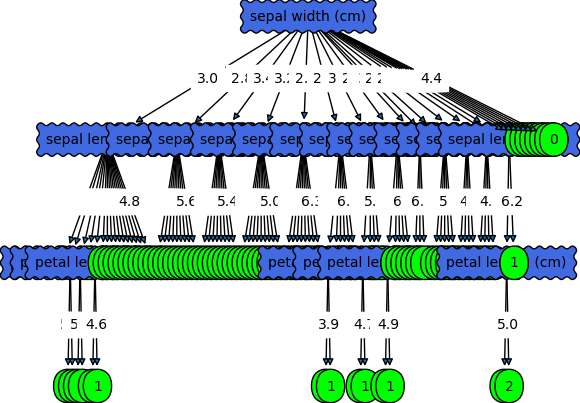

In [76]:
from treeplotter import create_plot

create_plot(test_tree_ID3)

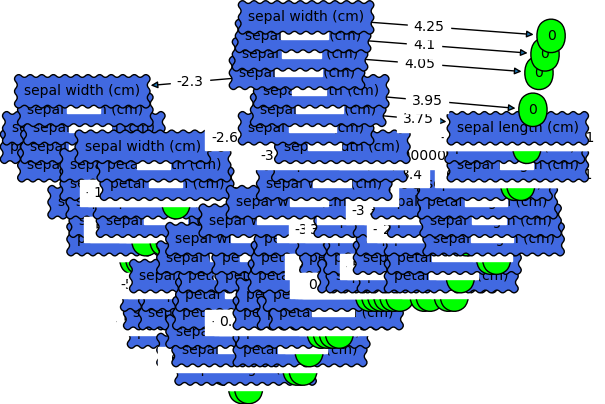

In [77]:
create_plot(test_tree_C45)

由上述可视化结果可以发现，决策树的分支过多，可视化效果不佳。

---

## 4 验证集评估
在评价过程中使用了F1-score的评价方式，计算准确率的方式如下。

首先定义以下4中情形：
- TP(True Positive)：真实类别和预测类别都是正例。
- FP(False Positive)：真实类别负例，预测类别正例。
- TN(True Negative)：真实类别和预测类别都是负例。
- FN(False Negative)：真是类别正例，预测类别负例。
  
因此可以定义精确率/查准率和召回率/查全率如下：

$$ Precision = \frac{TP}{TP+FP} $$
$$ Recall = \frac{TP}{TP+FN} $$

F1的计算方式：
$$ F1 = \frac{2\times P\times R}{P+R} $$

本次实验使用sklearn库中F1_score函数实现

### 4.1 Micro-F1

Micro即先计算总体的TP、FP、FN，然后再计算F1值。对于多分类来说，正负例的情况是相对而言的。比如，将分类为1的例子看作正例，那么分类不为1的模型测试出来的结果即位负。

Micro的TP是实际分类和测试分类相同的例子的数量，FP是不属于某一类别被分到某一类别的例子数量，FN是本该属于某一类别但是没有分到这一类别的数量。

对每一类标签执行以上操作，将得到的TP等值相加。

In [78]:
print("ID3-Micro-F1: %f"% f1_score(list(X_test.iloc[:,-1].values),result_ID3,average="micro"))
print("C4.5-Micro-F1: %f"% f1_score(list(X_test.iloc[:,-1].values),result_C45,average="micro"))

ID3-Micro-F1: 0.600000
C4.5-Micro-F1: 0.866667


### 4.2 Macro-F1
macro与micro不同主要在于：macro先计算每一类的F1-score，然后取均值赋为macro的值。

In [79]:
print("ID3-Macro-F1: %f"% f1_score(list(X_test.iloc[:,-1].values),result_ID3,average="macro"))
print("C4.5-Macro-F1: %f"% f1_score(list(X_test.iloc[:,-1].values),result_C45,average="macro"))

ID3-Macro-F1: 0.561966
C4.5-Macro-F1: 0.766667


由以上两组对比可见C4.5算法在Iris数据集上构造决策树的效果要优于ID3算法。因为C4.5更适用于连续值的划分，而ID3算法通常只适用于离散值的划分。

---

## 6 参考资料
1. https://zhuanlan.zhihu.com/p/112161073
2. https://blog.csdn.net/lyb3b3b/article/details/84819931